In [1]:
from __future__ import absolute_import, division, print_function
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm       # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

from termcolor import colored
import tensorflow as tf
import os                   # work with directories
import numpy as np          # dealing with arrays
import matplotlib.pyplot as plt
import time
import gc
tfe = tf.contrib.eager
import pickle as pk
import random
import sys

from tensorflow.contrib.summary import summary_test_util
from tensorflow.python.client import device_lib
from tensorflow.python.eager import tape

import gc 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
layers = tf.keras.layers
tf.enable_eager_execution(config=config)
tf.executing_eagerly()
print(tf.__version__)

HOME_DIR = '/home/moe/PycharmProjects/clean_code/'
MAIN_dir = '/home/moe/PycharmProjects/clean_code/Cleaned_code/'
MASK_path = MAIN_dir + 'mask/mask_binary_mod.bmp'


1.12.0


In [2]:
#  data shuffling is done through this, so there is no need to shuffle it in tensorflow
randomize = False
if randomize:
    randomized = "_randomized_"
else: 
    randomized = "_"
pickle_in_train = open(MAIN_dir + 'data_files/' + "training"+randomized+"dataset.pickle", "rb")
training_data = pk.load(pickle_in_train)
pickle_in_train.close()

pickle_in_validate = open(MAIN_dir + 'data_files/' + "validation"+randomized+"dataset.pickle", "rb")
validation_data = pk.load(pickle_in_validate)
pickle_in_validate.close()
pickle_in_test = open(MAIN_dir + 'data_files/' + "testing"+randomized+"dataset.pickle", "rb")
testing_data = pk.load(pickle_in_test)
pickle_in_test.close()



training_path = training_data['img_path']
training_weight = np.float32(np.reshape(training_data['weight'], [-1, 1]))
training_speed = np.reshape(training_data['speed'], [-1, 1])
training_volume = np.reshape(training_data['volume'], [-1, 1])
training_log_length = np.float32(training_data['log_length'])


validation_path = validation_data['img_path']
validation_weight = np.float32(np.reshape(validation_data['weight'], [-1, 1]))
validation_speed = np.reshape(validation_data['speed'], [-1, 1])
validation_volume = np.reshape(validation_data['volume'], [-1, 1])
validation_log_length = np.float32(validation_data['log_length'])


testing_path = testing_data['img_path']
testing_weight = np.float32(np.reshape(testing_data['weight'], [-1, 1]))
testing_speed = np.reshape(testing_data['speed'], [-1, 1])
testing_volume = np.reshape(testing_data['volume'], [-1, 1])
testing_log_length = np.float32(testing_data['log_length'])

std_mean_data = np.load(MAIN_dir + 'data_files/' + "std_mean_60_dataset.npy")
mean_std = np.array(std_mean_data, dtype="float32")


index = random.randint(1, len(testing_log_length))

print('ch1_mean',std_mean_data[2],'mean=', std_mean_data[6], ' std= ', std_mean_data[7])
# print(mean_std.dtype)

print(' ', testing_path[index], ' ', testing_weight[index], ' ', testing_speed[index], ' ',testing_volume[index],' ', testing_log_length[index], index, 
      '\n\n')

print(np.shape(training_path), np.shape(training_weight), np.shape(training_speed),np.shape(training_volume), np.shape(training_log_length))
# print(std_mean_data)



ch1_mean 97.59649670930388 mean= 62.383118295426804  std=  51.31584701596993
  /home/moe/Desktop/bambo_Logs/Data/my_dataset/testing/2015_07_21_1215_bamb_74_624/624_0_6560.856-1.768872.bmp   [624.]   [1.768872]   [8.075742]   749.0 1789 


(70002,) (70002, 1) (70002, 1) (70002, 1) (70002,)


In [3]:

def parse_function(filename, weight, speed, log_length):
    # Get the image as raw bytes.
    image_name = tf.read_file(filename)
    # Decode the raw bytes so it becomes a tensor with type.
    image = tf.image.decode_bmp(image_name, channels=3)
    
    # The type is now uint8 but we need it to be float.
    image = tf.to_float(image)
    # image = tf.cast(image, dtype="float32")

    return image, weight, speed, log_length


def data_normalization(image, weight, speed, log_length):
    mean_std = np.load(MAIN_dir + 'data_files/' + "std_mean_60_dataset.npy")  
    mean = [mean_std[0], mean_std[2], mean_std[4]]
    std_dev = [mean_std[1], mean_std[3], mean_std[5]]
    mean = tf.reshape(mean, [1, 1, 3])
    std_dev = tf.reshape(std_dev, [1, 1, 3])
    img_m = image - mean
    image = img_m / std_dev
  
    return image, weight, speed, log_length
# normalization should be applied to the entire dataset


def data_resize(image, weight, speed, log_length):
    resized_image = tf.image.resize_images(image, size=(96, 144))
  
    return resized_image, weight, speed, log_length


def data_masking(image, weight, speed, log_length):
    mask_name = tf.read_file(MASK_path)
    mask = tf.image.decode_bmp(mask_name, channels=3)
    mask = tf.to_float(mask)
    mask = tf.image.resize_images(mask, size=(96, 144))
    masked_img = tf.multiply(image, mask)
    # masked_img = tf.image.convert_image_dtype(masked_img, tf.float32)
    
    return masked_img, weight, speed, log_length


In [4]:
def compute_loss(prediction, label, train_log_length_, operation='L2'):
    if operation == 'L2':
        return tf.divide(tf.squared_difference(prediction, label), train_log_length_)
    elif operation == 'Subtraction':
        return tf.divide(tf.subtract(prediction, label), train_log_length_)
    elif operation == 'L1':
        return tf.divide(tf.abs(tf.subtract(prediction, label)), train_log_length_)
    else:
        raise ValueError('Please specify loss function (L2, L1, Subtraction)')


def print_progress(count, total, cnt, overall, time_, count_log, loss, loss_):
    percent_complete = float(count) / total
    overall_complete = float(cnt) / (overall-1)

    sec = time_ % 60
    mint = int(time_/60) % 60
    hr = int(time_/3600) % 60
    loss = str(loss)
    loss_ = str(loss_)
    msg = "\r Time_lapsed (hr:mm:ss) --> {0:02d}:{1:02d}:{2:02d} ,   loss: {3:s}   Log Progress: {4:.1%},     Overall Progress:{5:.1%}," \
        " completed {6:d} out of 185 logs <--> Initial loss: {7:s} ".format(hr, mint, sec, loss, percent_complete, overall_complete, count_log, loss_)
    sys.stdout.write(msg)
    sys.stdout.flush()
    

def validation_progress(log_cnt, num_logs, time_, loss, accuracy_loc):
    log_cnt += 1
    overall_complete = float(log_cnt) / num_logs
    sec = int(time_) % 60
    mint = int(time_/60) % 60
    hr = int(time_/3600) % 60
    loss = str(loss)
    msg = "\r Validation_Time (hr:mm:ss) --> {0:02d}:{1:02d}:{2:02d} ,   Avg_loss: {3:s}   Avg_accuracy: {4:.1%}   Overall Progress:{5:.1%}," \
        " completed {6:d} out of {7:d} logs".format(hr, mint, sec, loss, accuracy_loc, overall_complete, log_cnt, num_logs)
    sys.stdout.write(colored(msg, 'green'))
    sys.stdout.flush()


def write_summaries(loss, i, global_step, vars_loc, grads_loc, train=True):
    with summary_writer.as_default():
        # global_step.assign_add(1)
        with tf.contrib.summary.always_record_summaries():
            if train:
                tf.contrib.summary.scalar("train_loss", loss, step=global_step)
                tf.contrib.summary.scalar("step", i, step=global_step)
                #  do not add spaces after names
                tf.contrib.summary.histogram("weights", vars_loc, step=global_step)
                tf.contrib.summary.histogram("gradients", grads_loc, step=global_step)
            else:
                tf.contrib.summary.scalar("val_loss", loss, step=global_step)


In [5]:
Batch_size = 40
Buffer_size = 40
Epochs = 100
train_dataset = tf.data.Dataset.from_tensor_slices((training_path, training_weight, training_speed, training_log_length))
train_dataset = train_dataset.map(parse_function, num_parallel_calls=8)
train_dataset = train_dataset.map(data_resize, num_parallel_calls=8)
train_dataset = train_dataset.map(data_normalization, num_parallel_calls=8)
train_dataset = train_dataset.map(data_masking, num_parallel_calls=8)
train_dataset = train_dataset.batch(Batch_size)
# train_dataset = train_dataset.repeat(Epochs)
train_dataset = train_dataset.prefetch(Batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((testing_path, testing_weight, testing_speed, testing_log_length))
test_dataset = test_dataset.map(parse_function, num_parallel_calls=8)
test_dataset = test_dataset.map(data_resize, num_parallel_calls=8)
test_dataset = test_dataset.map(data_normalization, num_parallel_calls=8)
test_dataset = test_dataset.map(data_masking, num_parallel_calls=8)
test_dataset = test_dataset.batch(Batch_size)
# test_dataset = test_dataset.repeat(Epochs)
test_dataset = test_dataset.prefetch(Batch_size)


validation_dataset = tf.data.Dataset.from_tensor_slices((validation_path, validation_weight, validation_speed, validation_log_length))
validation_dataset = validation_dataset.map(parse_function, num_parallel_calls=8)
validation_dataset = validation_dataset.map(data_resize, num_parallel_calls=8)
validation_dataset = validation_dataset.map(data_normalization, num_parallel_calls=8)
validation_dataset = validation_dataset.map(data_masking, num_parallel_calls=8)
validation_dataset = validation_dataset.batch(Batch_size)
# test_dataset = test_dataset.repeat(Epochs)
validation_dataset = validation_dataset.prefetch(Batch_size)

from Cleaned_code import resnet50_ELU as resnet50
# from Cleaned_code import resnet50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(96, 144, 3)


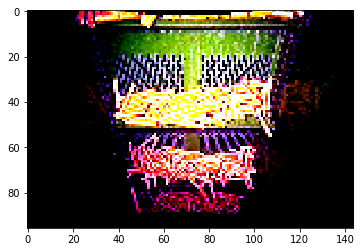

In [22]:
# for (batch, (images, labels, speeds, log_length)) in enumerate(train_dataset):
#     if batch == 200:
#         # plt.imshow((images[0].numpy()*255).astype(np.uint8))
#         plt.imshow(images[0])
#         print(images[0].numpy().shape)
#         break

(480, 720, 3)


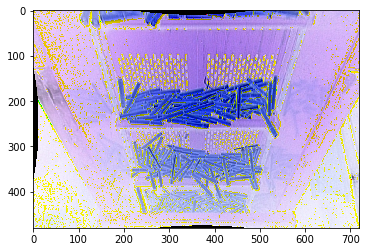

In [8]:
# for (batch, (images, labels, speeds, log_length)) in enumerate(train_dataset):
#     if batch == 200:
#         plt.imshow((images[0].numpy()*255).astype(np.uint8))
#         
#         print(images[0].numpy().shape)
#         break

In [6]:
#  model is an object of ResNet50, so it can use all the functions in it. and it is passed as self

data_format = 'channels_last'
model = resnet50.ResNet50(data_format=data_format, include_top=True, pooling=None, classes=1)
optimizer = tf.train.AdamOptimizer()
accuracy = 0 
acc_prediction = tf.constant(0, dtype="float32")
t = tf.constant(1/7.5, dtype="float32")
loss = tf.constant(0, dtype="float32")
logdir = MAIN_dir+'tensorboard_reporting/'
checkpont_path = MAIN_dir+"checkpoints/cp-{log:04d}.ckpt"
checkpont_dir = os.path.dirname(checkpont_path)
summary_writer = tf.contrib.summary.create_file_writer(logdir)
# tf.keras.initializers.he_normal(seed=None)


In [7]:
# VALIDATION CODE


def validate_model(model_loc, val_step_, n_logs, data_set, write_summary=True, return_losses=True):
    logs_N = n_logs
    start = time.time()
    MAE = []
    MSE = []
    MSBE = []
    Accuracy = []
    metric_mse = []
    summed_volume = 0
    remainder = 0
    iterations = 0
    fixed_size = 0
    count = 0
    new_log = True
    cnt_log = -1
    signal = []
    signals = []
    log_order = []
    for (batch, (images, labels, speeds, log_length)) in enumerate(data_set):
        batch += 1
        if new_log:           
            new_log = False
            length = int(log_length[0].numpy() - fixed_size + remainder)
            iterations = int(np.floor(length/Batch_size))
            remainder = int(np.mod(length, Batch_size))
            fixed_size = np.shape(speeds)[0]
            cnt_log += 1

        if count < iterations:
            mass_pred = model_loc(images)
            volume = (mass_pred * speeds) * t
            summed_volume += tf.reduce_sum(volume)
            mass = summed_volume.numpy()
            count = count + 1
            signal.append(volume)
            # Compute loss
            if count == iterations and remainder == 0:
                loss_unsigned = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L2').numpy())
                loss_outlier = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L1').numpy())
                loss_signed = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='Subtraction').numpy())
                MSE.append(loss_unsigned)
                MAE.append(loss_outlier)
                MSBE.append(loss_signed)
                signals.append(signal[0:len(signal)])
                signal.clear()
        
                gt = np.squeeze(labels[0].numpy())
                if gt >= 200 and gt != 501:  # used for testing
                    metric_mse.append(loss_unsigned)
                    if mass > gt:
                        log_acc = np.squeeze((gt+1)/(mass+1))
                    else:
                        log_acc = np.squeeze((mass+1)/(gt+1))
                    Accuracy.append(log_acc)
                    log_order.append(np.squeeze(log_length[0].numpy()))
                    time_ = time.time() - start
                    validation_progress(cnt_log, logs_N, time_, np.mean(metric_mse), np.mean(Accuracy))
                if write_summary:
                    write_summaries(np.mean(MSE), 0, val_step_, 0, 0, train=False)
                val_step_ += 1
                # Reset
                summed_volume = 0
                count = 0
                fixed_size = 0
                new_log = True
        # Handle the remainder from iterations
        else:
            # Compute and Aggregate the remainder Gradients
            mass_pred = model(images[0:remainder])
            volume = (mass_pred * speeds[0:remainder]) * t
            summed_volume += tf.reduce_sum(volume)
            mass = summed_volume.numpy()
            signal.append(volume)
            
            loss_unsigned = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L2').numpy())
            loss_outlier = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L1').numpy())
            loss_signed = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='Subtraction').numpy())
            MSE.append(loss_unsigned)
            MAE.append(loss_outlier)
            MSBE.append(loss_signed)
            signals.append(signal[0:len(signal)])
            signal.clear()
            
            gt = np.squeeze(labels[0].numpy())
            if gt >= 200 and gt != 501:  # used for testing
                metric_mse.append(loss_unsigned)
                if mass > gt:
                    log_acc = np.squeeze((gt+1)/(mass+1))
                else:
                    log_acc = np.squeeze((mass+1)/(gt+1))
                Accuracy.append(log_acc)
                log_order.append(np.squeeze(log_length[0].numpy()))
                time_ = time.time() - start
                validation_progress(cnt_log, logs_N, time_, np.mean(metric_mse), np.mean(Accuracy))  
            
            if write_summary:  
                write_summaries(np.mean(MSE), 0, val_step_, 0, 0, train=False)
            val_step_ += 1
            summed_volume = 0
            count = 0
            new_log = True
            
            # Handle gradients for the next log
            if cnt_log != logs_N-1:    
                mass_pred = model(images[remainder:])
                volume = (mass_pred * speeds[remainder:]) * t
                summed_volume += tf.reduce_sum(volume)
                signal.append(volume)
                
    if return_losses:
        return MSE, MAE, MSBE, Accuracy, val_step_
    else: 
        return signals

In [8]:
model.load_weights(MAIN_dir+'checkpoints/cp-0030.ckpt')

In [8]:
# TRAINING CODE
save_epoch = 40
loss_ = 0
logs_N = 143
start = time.time()
aggregated = []
MSE_log = []
MAE_log = []
MSBE_log = []
MSE_t = []
MAE_t = []
MSBE_t = []
MSE_avg = []
MAE_avg = []
MSBE_avg = []
MSE_train = []
val_step = 0
run_name = 'volume'
r_volume = 0
for epoch in range(Epochs):
    loss_metric = 0
    summed_volume = 0
    remainder = 0
    iterations = 0
    fixed_size = 0
    count = 0
    new_log = True
    append_flag = True
    next_log = False
    cnt_log = -1
    first_run = True
    for (batch, (images, labels, speeds, log_length)) in enumerate(train_dataset):
        batch += 1
        step = tf.train.get_or_create_global_step()
        if new_log:           
            new_log = False
            length = int(log_length[0].numpy() - fixed_size + remainder)
            iterations = int(np.floor(length/Batch_size))
            remainder = int(np.mod(length, Batch_size))
            fixed_size = np.shape(speeds)[0]
            cnt_log += 1

        if count < iterations:
            
            # Compute and Aggregate Gradients
            with tf.GradientTape() as tape:
                mass_pred = model(images)
                volume = (mass_pred * speeds) * t
                r_volume = tf.reduce_sum(volume)
                summed_volume += tf.reduce_sum(volume)
                watched_vars = tape.watched_variables()
            grads = tape.gradient(r_volume, model.trainable_variables)

            if count == 0 and append_flag:
                for grad in grads:
                    aggregated.append(grad)
            else:
                for idx, grad in enumerate(grads):
                    aggregated[idx] = grad+aggregated[idx]
            
            count = count + 1

            # Compute loss and Apply Gradients
            if count == iterations and remainder == 0:
                loss = compute_loss(summed_volume, labels[0], log_length[0], operation='Subtraction')
                loss_metric = tf.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L2').numpy())
                for idx, grd in enumerate(aggregated):
                    aggregated[idx] = loss * 2 * grd
                rmse = tf.sqrt(tf.abs(loss_metric))
                optimizer.apply_gradients(zip(aggregated, model.trainable_variables), global_step=step)
                var_list = model.variables
                write_summaries(loss_metric, batch, step, var_list[0], grads[0], train=True)
                end = time.time() - start
                sec = int(end % 60)
                mint = int(end/60) % 60
                hr = int(end/3600) % 60
                print("\r Time_lapsed (hr:mm:ss) --> {:02d}:{:02d}:{:02d} Epoch: {}, Log: {}, Log_progress: {:.1%} - Overall_progress: {:.1%}, Length: {} "
                "Label:{}, loss: {:.3f}, train RMSE: {:.2f}".format(hr, mint, sec, epoch+1, cnt_log+1, (cnt_log+1)/logs_N, (epoch+1)/Epochs,  
                log_length[0].numpy(), labels[0].numpy(), loss_metric, rmse))
                
                if first_run:
                    first_run = False
                    loss_ = loss_metric.numpy()
                
                # Reset
                aggregated.clear()
                summed_volume = 0
                count = 0
                append_flag = True
                fixed_size = 0
                new_log = True
            
        # Handle the remainder from iterations
        else:
            # Compute and Aggregate the remainder Gradients
            with tf.GradientTape() as tape:
                mass_pred = model(images[0:remainder])
                volume = (mass_pred * speeds[0:remainder]) * t
                r_volume = tf.reduce_sum(volume)
                summed_volume += tf.reduce_sum(volume)
                watched_vars = tape.watched_variables()
            grads = tape.gradient(r_volume, model.trainable_variables)

            for idx, grad in enumerate(grads):
                aggregated[idx] = grad+aggregated[idx]
            
            # Compute loss and apply gradients for the remainder
            loss = compute_loss(summed_volume, labels[0], log_length[0], operation='Subtraction')
            loss_metric = tf.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L2').numpy())
            for idx, grd in enumerate(aggregated):
                aggregated[idx] = loss * 2 * grd
            rmse = tf.squeeze(tf.sqrt(tf.abs(loss_metric)))
            optimizer.apply_gradients(zip(aggregated, model.trainable_variables), global_step=step)
            var_list = model.trainable_variables
            write_summaries(loss_metric, batch, step, var_list[0], grads[0], train=True)
            end = time.time() - start
            sec = int(end % 60)
            mint = int(end/60) % 60
            hr = int(end/3600) % 60
            print("\r Time_lapsed (hr:mm:ss) --> {:02d}:{:02d}:{:02d} Epoch: {}, Log: {}, Log_progress: {:.1%} - Overall_progress: {:.1%}, Length: {} "
                  "Label:{}, loss: {:.3f}, train RMSE: {:.2f}".format(hr, mint, sec, epoch+1, cnt_log+1, (cnt_log+1)/logs_N, (epoch+1)/Epochs,  
                  log_length[0].numpy(), labels[0].numpy(), loss_metric, rmse))

            if first_run:
                first_run = False
                loss_ = loss_metric.numpy()
            
            # Reset
            aggregated.clear()
            summed_volume = 0
            count = 0
            append_flag = True
            new_log = True
             
            # Handle gradients for the next log
            if cnt_log != logs_N-1:
                # Compute and Aggregate Gradients
                with tf.GradientTape() as tape:
                    mass_pred = model(images[remainder:])
                    volume = (mass_pred * speeds[remainder:]) * t
                    r_volume = tf.reduce_sum(volume)
                    summed_volume += tf.reduce_sum(volume)
                    watched_vars = tape.watched_variables()
                grads = tape.gradient(r_volume, model.trainable_variables)

                for grad in grads:
                    aggregated.append(grad)
                append_flag = False

    # save model weights every epoch after 50 epochs lapsed
    if epoch >= save_epoch:
        model.save_weights(checkpont_path.format(log=epoch))
        
    # Validate model every epoch to determine early stopping
    MSE_log, MAE_log, MSBE_log, accuracy_, val_step = validate_model(model, val_step, 48, validation_dataset, write_summary=True,
                                                                     return_losses=True)
    print('\n')
    MSE_t.append(MSE_log)   # contains log losses for each epoch
    MAE_t.append(MAE_log)
    MSBE_t.append(MSBE_log)
    MSE_avg.append(np.mean(MSE_log))    # contains average log losses for each epoch
    MAE_avg.append(np.mean(MAE_log))
    MSBE_avg.append(np.mean(MSBE_log))
    MSE_train.append(loss_metric)
    error = 1 - np.mean(accuracy_)
    full_data_dict= {"MSE_t": MSE_t, "MAE_t": MAE_t, "MSBE_t": MSBE_t, "MSE_avg": MSE_avg, "MAE_avg": MAE_avg, "MSBE_avg": MSBE_avg, "MSE_train": MSE_train}
    pickle_out = open(MAIN_dir+"data_files/"+"losses_"+run_name+".pickle", "wb")
    pk.dump(full_data_dict, pickle_out)
    pickle_out.close()
    if error <= 0.08:
        epoch = 1000   # end training
        break
    
    # MSE_t = np.append([MSE_log], [np.mean(MSE_log)])
    # saver = tfe.Saver(model.variables)
    # saver.save(checkpont_path.format(log=epoch))1'3=,./adeflmnotv
# model.save('my_dataset_model_keras.h5')-
# model.save_weights('my_dataset_model.h5')2dhpty-

 Time_lapsed (hr:mm:ss) --> 00:00:06 Epoch: 1, Log: 1, Log_progress: 0.7% - Overall_progress: 1.0%, Length: 638.0 Label:[649.], loss: 763.290, train RMSE: 27.63


 Time_lapsed (hr:mm:ss) --> 00:00:08 Epoch: 1, Log: 2, Log_progress: 1.4% - Overall_progress: 1.0%, Length: 511.0 Label:[640.], loss: 29.354, train RMSE: 5.42


 Time_lapsed (hr:mm:ss) --> 00:00:10 Epoch: 1, Log: 3, Log_progress: 2.1% - Overall_progress: 1.0%, Length: 397.0 Label:[635.], loss: 3560.473, train RMSE: 59.67


In [ ]:
model.save_weights('/home/moe/PycharmProjects/step_step/Cleaned_code/checkpoints/checkpoint_31')
# model.load_weights(MAIN_dir+'checkpoints/checkpoint_92_1_accurate')
# model.load_weights(MAIN_dir+'checkpoints/cp-01291.ckpt')

In [ ]:
# model.save('/home/moe/PycharmProjects/step_step/checkpoints/weights_7logs/my_7logs_model.h5')

print(len(grads), len(model.trainable_variables))


In [9]:


model.load_weights(MAIN_dir+'checkpoints/cp-0199.ckpt')

In [10]:
signals = validate_model(model, 1, 143, train_dataset, write_summary=False, return_losses=False)

 Validation_Time (hr:mm:ss) --> 00:00:03 ,   Avg_loss: 8.923889   Avg_accuracy: 89.6%   Overall Progress:0.7%, completed 1 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:05 ,   Avg_loss: 6.5408154   Avg_accuracy: 91.4%   Overall Progress:1.4%, completed 2 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:07 ,   Avg_loss: 4.9596915   Avg_accuracy: 93.0%   Overall Progress:2.1%, completed 3 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:08 ,   Avg_loss: 4.673005   Avg_accuracy: 93.2%   Overall Progress:2.8%, completed 4 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:10 ,   Avg_loss: 5.3150053   Avg_accuracy: 93.2%   Overall Progress:3.5%, completed 5 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:15 ,   Avg_loss: 4.8473496   Avg_accuracy: 93.1%   Overall Progress:4.2%, completed 6 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:16 ,   Avg_loss: 9.575041   Avg_accuracy: 91.2%   Overall Progress:4.9%, completed 7 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:19 ,   Avg_loss: 8.567991   Avg_accuracy: 91.7%   Overall Progress:5.6%, completed 8 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:21 ,   Avg_loss: 8.565401   Avg_accuracy: 91.7%   Overall Progress:6.3%, completed 9 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:23 ,   Avg_loss: 7.7571855   Avg_accuracy: 92.3%   Overall Progress:7.0%, completed 10 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:25 ,   Avg_loss: 7.486775   Avg_accuracy: 92.4%   Overall Progress:7.7%, completed 11 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:26 ,   Avg_loss: 7.4421716   Avg_accuracy: 92.5%   Overall Progress:8.4%, completed 12 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:28 ,   Avg_loss: 7.5348864   Avg_accuracy: 92.4%   Overall Progress:9.1%, completed 13 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:30 ,   Avg_loss: 7.175033   Avg_accuracy: 92.6%   Overall Progress:9.8%, completed 14 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:31 ,   Avg_loss: 6.792842   Avg_accuracy: 92.9%   Overall Progress:10.5%, completed 15 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:32 ,   Avg_loss: 6.7855606   Avg_accuracy: 92.9%   Overall Progress:11.2%, completed 16 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:34 ,   Avg_loss: 6.4202714   Avg_accuracy: 93.2%   Overall Progress:11.9%, completed 17 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:35 ,   Avg_loss: 6.195887   Avg_accuracy: 93.3%   Overall Progress:12.6%, completed 18 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:38 ,   Avg_loss: 5.902739   Avg_accuracy: 93.5%   Overall Progress:13.3%, completed 19 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:41 ,   Avg_loss: 5.639138   Avg_accuracy: 93.7%   Overall Progress:14.0%, completed 20 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:44 ,   Avg_loss: 5.410531   Avg_accuracy: 93.8%   Overall Progress:14.7%, completed 21 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:46 ,   Avg_loss: 5.230543   Avg_accuracy: 93.9%   Overall Progress:15.4%, completed 22 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:47 ,   Avg_loss: 5.01219   Avg_accuracy: 94.1%   Overall Progress:16.1%, completed 23 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:49 ,   Avg_loss: 4.816876   Avg_accuracy: 94.3%   Overall Progress:16.8%, completed 24 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:53 ,   Avg_loss: 4.646497   Avg_accuracy: 94.4%   Overall Progress:17.5%, completed 25 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:56 ,   Avg_loss: 4.499485   Avg_accuracy: 94.4%   Overall Progress:18.2%, completed 26 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:00:58 ,   Avg_loss: 4.3734384   Avg_accuracy: 94.5%   Overall Progress:18.9%, completed 27 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:01 ,   Avg_loss: 4.217793   Avg_accuracy: 94.7%   Overall Progress:19.6%, completed 28 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:04 ,   Avg_loss: 4.132163   Avg_accuracy: 94.7%   Overall Progress:20.3%, completed 29 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:05 ,   Avg_loss: 4.0260844   Avg_accuracy: 94.8%   Overall Progress:21.0%, completed 30 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:08 ,   Avg_loss: 3.909082   Avg_accuracy: 94.9%   Overall Progress:21.7%, completed 31 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:09 ,   Avg_loss: 3.7896333   Avg_accuracy: 95.0%   Overall Progress:22.4%, completed 32 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:11 ,   Avg_loss: 3.687283   Avg_accuracy: 95.1%   Overall Progress:23.1%, completed 33 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:12 ,   Avg_loss: 3.5792704   Avg_accuracy: 95.2%   Overall Progress:23.8%, completed 34 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:15 ,   Avg_loss: 3.478904   Avg_accuracy: 95.3%   Overall Progress:24.5%, completed 35 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:18 ,   Avg_loss: 3.3829918   Avg_accuracy: 95.4%   Overall Progress:25.2%, completed 36 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:23 ,   Avg_loss: 3.3086462   Avg_accuracy: 95.5%   Overall Progress:26.6%, completed 38 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:27 ,   Avg_loss: 3.2362983   Avg_accuracy: 95.5%   Overall Progress:27.3%, completed 39 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:29 ,   Avg_loss: 3.1565082   Avg_accuracy: 95.6%   Overall Progress:28.0%, completed 40 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:30 ,   Avg_loss: 3.0780473   Avg_accuracy: 95.7%   Overall Progress:28.7%, completed 41 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:32 ,   Avg_loss: 3.0117047   Avg_accuracy: 95.8%   Overall Progress:29.4%, completed 42 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:33 ,   Avg_loss: 2.9400036   Avg_accuracy: 95.9%   Overall Progress:30.1%, completed 43 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:34 ,   Avg_loss: 2.8756287   Avg_accuracy: 95.9%   Overall Progress:30.8%, completed 44 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:37 ,   Avg_loss: 2.8104696   Avg_accuracy: 96.0%   Overall Progress:31.5%, completed 45 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:40 ,   Avg_loss: 2.8151636   Avg_accuracy: 96.0%   Overall Progress:32.2%, completed 46 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:42 ,   Avg_loss: 2.7597947   Avg_accuracy: 96.0%   Overall Progress:32.9%, completed 47 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:45 ,   Avg_loss: 2.730108   Avg_accuracy: 96.0%   Overall Progress:33.6%, completed 48 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:48 ,   Avg_loss: 2.6740952   Avg_accuracy: 96.1%   Overall Progress:34.3%, completed 49 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:50 ,   Avg_loss: 2.6245093   Avg_accuracy: 96.1%   Overall Progress:35.0%, completed 50 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:52 ,   Avg_loss: 2.577774   Avg_accuracy: 96.2%   Overall Progress:35.7%, completed 51 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:54 ,   Avg_loss: 2.5582805   Avg_accuracy: 96.2%   Overall Progress:36.4%, completed 52 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:55 ,   Avg_loss: 2.5091143   Avg_accuracy: 96.2%   Overall Progress:37.1%, completed 53 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:01:58 ,   Avg_loss: 2.4653275   Avg_accuracy: 96.3%   Overall Progress:37.8%, completed 54 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:01 ,   Avg_loss: 2.425236   Avg_accuracy: 96.3%   Overall Progress:38.5%, completed 55 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:04 ,   Avg_loss: 2.4029255   Avg_accuracy: 96.3%   Overall Progress:39.2%, completed 56 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:18 ,   Avg_loss: 2.37971   Avg_accuracy: 96.2%   Overall Progress:39.9%, completed 57 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:23 ,   Avg_loss: 2.3382218   Avg_accuracy: 96.2%   Overall Progress:40.6%, completed 58 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:25 ,   Avg_loss: 2.2985983   Avg_accuracy: 96.3%   Overall Progress:41.3%, completed 59 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:26 ,   Avg_loss: 2.2806597   Avg_accuracy: 96.3%   Overall Progress:42.0%, completed 60 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:28 ,   Avg_loss: 2.2449584   Avg_accuracy: 96.3%   Overall Progress:42.7%, completed 61 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:29 ,   Avg_loss: 2.2128947   Avg_accuracy: 96.4%   Overall Progress:43.4%, completed 62 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:32 ,   Avg_loss: 2.2127585   Avg_accuracy: 96.4%   Overall Progress:44.1%, completed 63 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:34 ,   Avg_loss: 2.2039726   Avg_accuracy: 96.3%   Overall Progress:44.8%, completed 64 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:37 ,   Avg_loss: 2.1702342   Avg_accuracy: 96.4%   Overall Progress:45.5%, completed 65 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:39 ,   Avg_loss: 2.202884   Avg_accuracy: 96.3%   Overall Progress:46.2%, completed 66 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:42 ,   Avg_loss: 2.1986566   Avg_accuracy: 96.3%   Overall Progress:46.9%, completed 67 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:43 ,   Avg_loss: 2.2384636   Avg_accuracy: 96.3%   Overall Progress:47.6%, completed 68 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:53 ,   Avg_loss: 2.36707   Avg_accuracy: 96.2%   Overall Progress:50.3%, completed 72 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:55 ,   Avg_loss: 2.5081894   Avg_accuracy: 96.1%   Overall Progress:51.0%, completed 73 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:02:58 ,   Avg_loss: 2.7251894   Avg_accuracy: 95.9%   Overall Progress:51.7%, completed 74 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:00 ,   Avg_loss: 2.859535   Avg_accuracy: 95.8%   Overall Progress:52.4%, completed 75 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:02 ,   Avg_loss: 2.9713385   Avg_accuracy: 95.8%   Overall Progress:53.1%, completed 76 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:03 ,   Avg_loss: 3.0790431   Avg_accuracy: 95.7%   Overall Progress:53.8%, completed 77 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:04 ,   Avg_loss: 3.1114342   Avg_accuracy: 95.7%   Overall Progress:54.5%, completed 78 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:05 ,   Avg_loss: 3.146142   Avg_accuracy: 95.7%   Overall Progress:55.2%, completed 79 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:07 ,   Avg_loss: 3.1371307   Avg_accuracy: 95.7%   Overall Progress:55.9%, completed 80 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:10 ,   Avg_loss: 3.1100798   Avg_accuracy: 95.7%   Overall Progress:56.6%, completed 81 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:13 ,   Avg_loss: 3.110694   Avg_accuracy: 95.6%   Overall Progress:57.3%, completed 82 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:16 ,   Avg_loss: 3.101203   Avg_accuracy: 95.6%   Overall Progress:58.0%, completed 83 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:18 ,   Avg_loss: 3.071933   Avg_accuracy: 95.6%   Overall Progress:58.7%, completed 84 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:20 ,   Avg_loss: 3.0344357   Avg_accuracy: 95.7%   Overall Progress:59.4%, completed 85 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:22 ,   Avg_loss: 3.0002832   Avg_accuracy: 95.7%   Overall Progress:60.1%, completed 86 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:23 ,   Avg_loss: 2.970039   Avg_accuracy: 95.7%   Overall Progress:60.8%, completed 87 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:24 ,   Avg_loss: 2.935107   Avg_accuracy: 95.8%   Overall Progress:61.5%, completed 88 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:26 ,   Avg_loss: 2.9007115   Avg_accuracy: 95.8%   Overall Progress:62.2%, completed 89 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:29 ,   Avg_loss: 2.9180427   Avg_accuracy: 95.8%   Overall Progress:62.9%, completed 90 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:32 ,   Avg_loss: 3.0173786   Avg_accuracy: 95.6%   Overall Progress:63.6%, completed 91 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:35 ,   Avg_loss: 3.1197991   Avg_accuracy: 95.5%   Overall Progress:64.3%, completed 92 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:38 ,   Avg_loss: 3.1440902   Avg_accuracy: 95.5%   Overall Progress:65.0%, completed 93 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:41 ,   Avg_loss: 3.1727972   Avg_accuracy: 95.4%   Overall Progress:65.7%, completed 94 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:43 ,   Avg_loss: 3.1383939   Avg_accuracy: 95.5%   Overall Progress:66.4%, completed 95 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:45 ,   Avg_loss: 3.1082313   Avg_accuracy: 95.5%   Overall Progress:67.1%, completed 96 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:46 ,   Avg_loss: 3.075023   Avg_accuracy: 95.5%   Overall Progress:67.8%, completed 97 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:47 ,   Avg_loss: 3.076783   Avg_accuracy: 95.5%   Overall Progress:68.5%, completed 98 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:53 ,   Avg_loss: 3.0772436   Avg_accuracy: 95.5%   Overall Progress:69.9%, completed 100 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:56 ,   Avg_loss: 3.0779839   Avg_accuracy: 95.5%   Overall Progress:70.6%, completed 101 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:03:59 ,   Avg_loss: 3.099194   Avg_accuracy: 95.4%   Overall Progress:71.3%, completed 102 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:02 ,   Avg_loss: 3.13361   Avg_accuracy: 95.4%   Overall Progress:72.0%, completed 103 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:06 ,   Avg_loss: 3.1366563   Avg_accuracy: 95.3%   Overall Progress:72.7%, completed 104 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:08 ,   Avg_loss: 3.123605   Avg_accuracy: 95.3%   Overall Progress:73.4%, completed 105 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:10 ,   Avg_loss: 3.096359   Avg_accuracy: 95.4%   Overall Progress:74.1%, completed 106 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:12 ,   Avg_loss: 3.0745687   Avg_accuracy: 95.4%   Overall Progress:74.8%, completed 107 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:14 ,   Avg_loss: 3.1085532   Avg_accuracy: 95.4%   Overall Progress:75.5%, completed 108 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:16 ,   Avg_loss: 3.1497393   Avg_accuracy: 95.3%   Overall Progress:76.2%, completed 109 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:18 ,   Avg_loss: 3.219806   Avg_accuracy: 95.3%   Overall Progress:76.9%, completed 110 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:19 ,   Avg_loss: 3.245965   Avg_accuracy: 95.3%   Overall Progress:77.6%, completed 111 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:20 ,   Avg_loss: 3.2659757   Avg_accuracy: 95.3%   Overall Progress:78.3%, completed 112 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:23 ,   Avg_loss: 3.2569184   Avg_accuracy: 95.3%   Overall Progress:79.0%, completed 113 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:26 ,   Avg_loss: 3.2707243   Avg_accuracy: 95.2%   Overall Progress:79.7%, completed 114 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:29 ,   Avg_loss: 3.2851884   Avg_accuracy: 95.2%   Overall Progress:80.4%, completed 115 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:31 ,   Avg_loss: 3.3500495   Avg_accuracy: 95.2%   Overall Progress:81.1%, completed 116 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:33 ,   Avg_loss: 3.4093692   Avg_accuracy: 95.1%   Overall Progress:81.8%, completed 117 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:35 ,   Avg_loss: 3.65736   Avg_accuracy: 95.0%   Overall Progress:82.5%, completed 118 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:36 ,   Avg_loss: 3.721858   Avg_accuracy: 95.0%   Overall Progress:83.2%, completed 119 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:37 ,   Avg_loss: 3.798915   Avg_accuracy: 95.0%   Overall Progress:83.9%, completed 120 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:39 ,   Avg_loss: 3.778055   Avg_accuracy: 95.0%   Overall Progress:84.6%, completed 121 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:41 ,   Avg_loss: 3.828958   Avg_accuracy: 94.9%   Overall Progress:85.3%, completed 122 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:42 ,   Avg_loss: 3.7996488   Avg_accuracy: 95.0%   Overall Progress:86.0%, completed 123 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:44 ,   Avg_loss: 3.798712   Avg_accuracy: 95.0%   Overall Progress:86.7%, completed 124 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:45 ,   Avg_loss: 3.7783763   Avg_accuracy: 95.0%   Overall Progress:87.4%, completed 125 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:46 ,   Avg_loss: 3.7476528   Avg_accuracy: 95.0%   Overall Progress:88.1%, completed 126 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:47 ,   Avg_loss: 3.7171464   Avg_accuracy: 95.1%   Overall Progress:88.8%, completed 127 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:48 ,   Avg_loss: 3.6878653   Avg_accuracy: 95.1%   Overall Progress:89.5%, completed 128 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:49 ,   Avg_loss: 3.7010474   Avg_accuracy: 95.1%   Overall Progress:90.2%, completed 129 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:52 ,   Avg_loss: 4.1279078   Avg_accuracy: 94.9%   Overall Progress:90.9%, completed 130 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:54 ,   Avg_loss: 4.3058467   Avg_accuracy: 94.8%   Overall Progress:91.6%, completed 131 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:04:57 ,   Avg_loss: 4.4141707   Avg_accuracy: 94.7%   Overall Progress:92.3%, completed 132 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:05:00 ,   Avg_loss: 4.403877   Avg_accuracy: 94.6%   Overall Progress:93.0%, completed 133 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:05:03 ,   Avg_loss: 4.3953023   Avg_accuracy: 94.6%   Overall Progress:93.7%, completed 134 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:05:06 ,   Avg_loss: 6.1397967   Avg_accuracy: 94.1%   Overall Progress:94.4%, completed 135 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:05:08 ,   Avg_loss: 6.1124287   Avg_accuracy: 94.2%   Overall Progress:95.1%, completed 136 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:05:09 ,   Avg_loss: 6.0663657   Avg_accuracy: 94.2%   Overall Progress:95.8%, completed 137 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:05:10 ,   Avg_loss: 6.021031   Avg_accuracy: 94.2%   Overall Progress:96.5%, completed 138 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:05:11 ,   Avg_loss: 6.0725727   Avg_accuracy: 94.2%   Overall Progress:97.2%, completed 139 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:05:12 ,   Avg_loss: 6.030864   Avg_accuracy: 94.2%   Overall Progress:97.9%, completed 140 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:05:14 ,   Avg_loss: 5.986916   Avg_accuracy: 94.3%   Overall Progress:98.6%, completed 141 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:05:15 ,   Avg_loss: 5.9517884   Avg_accuracy: 94.3%   Overall Progress:99.3%, completed 142 out of 143 logs

 Validation_Time (hr:mm:ss) --> 00:05:16 ,   Avg_loss: 6.010405   Avg_accuracy: 94.2%   Overall Progress:100.0%, completed 143 out of 143 logs

In [11]:

len(signals)

143

In [12]:
signal = []
signalz = []
onehot_signals = []
volume_signal = []
cnt = 0

for sig in tqdm(signals):
    for si in sig:
        for s in si:
            sm = np.float32(np.squeeze(s.numpy()))
            signal.append(sm)
            volume_signal.append(training_volume[cnt])
            onehot_signals.append(sm)
            cnt += 1
    signalz.append([training_path[cnt-1].split('/')[8], training_weight[cnt-1], training_log_length[cnt-1], signal[:len(signal)], 
                    volume_signal[:len(volume_signal)]])
    signal.clear()
    volume_signal.clear()

  0%|          | 0/143 [00:00<?, ?it/s]

  1%|▏         | 2/143 [00:00<00:10, 13.40it/s]

  3%|▎         | 5/143 [00:00<00:08, 15.36it/s]

  4%|▍         | 6/143 [00:00<00:11, 11.98it/s]

  6%|▌         | 8/143 [00:00<00:10, 12.80it/s]

  7%|▋         | 10/143 [00:00<00:09, 13.90it/s]

  8%|▊         | 12/143 [00:00<00:09, 14.37it/s]

 10%|█         | 15/143 [00:00<00:08, 15.84it/s]

 12%|█▏        | 17/143 [00:01<00:07, 15.99it/s]

 13%|█▎        | 19/143 [00:01<00:08, 15.35it/s]

 15%|█▍        | 21/143 [00:01<00:08, 14.58it/s]

 16%|█▌        | 23/143 [00:01<00:07, 15.79it/s]

 17%|█▋        | 25/143 [00:01<00:07, 15.12it/s]

 19%|█▉        | 27/143 [00:01<00:08, 14.22it/s]

 20%|██        | 29/143 [00:01<00:07, 14.73it/s]

 22%|██▏       | 31/143 [00:01<00:07, 15.31it/s]

 24%|██▍       | 35/143 [00:02<00:06, 17.14it/s]

 26%|██▌       | 37/143 [00:02<00:06, 15.86it/s]

 27%|██▋       | 39/143 [00:02<00:07, 14.75it/s]

 29%|██▉       | 42/143 [00:02<00:06, 16.76it/s]

 31%|███▏      | 45/143 [00:02<00:05, 18.02it/s]

 33%|███▎      | 47/143 [00:02<00:05, 16.48it/s]

 34%|███▍      | 49/143 [00:03<00:06, 15.06it/s]

 36%|███▋      | 52/143 [00:03<00:05, 16.37it/s]

 38%|███▊      | 54/143 [00:03<00:05, 17.05it/s]

 39%|███▉      | 56/143 [00:03<00:05, 16.72it/s]

 41%|████      | 58/143 [00:03<00:09,  8.97it/s]

 43%|████▎     | 61/143 [00:04<00:07, 10.95it/s]

 45%|████▍     | 64/143 [00:04<00:06, 12.59it/s]

 46%|████▌     | 66/143 [00:04<00:05, 13.36it/s]

 48%|████▊     | 68/143 [00:04<00:05, 14.71it/s]

 49%|████▉     | 70/143 [00:04<00:04, 15.40it/s]

 50%|█████     | 72/143 [00:04<00:04, 15.65it/s]

 52%|█████▏    | 74/143 [00:04<00:04, 16.07it/s]

 54%|█████▍    | 77/143 [00:04<00:03, 17.71it/s]

 57%|█████▋    | 81/143 [00:05<00:03, 19.18it/s]

 59%|█████▊    | 84/143 [00:05<00:03, 17.40it/s]

 61%|██████    | 87/143 [00:05<00:02, 19.12it/s]

 63%|██████▎   | 90/143 [00:05<00:02, 19.72it/s]

 65%|██████▌   | 93/143 [00:05<00:02, 17.22it/s]

 66%|██████▋   | 95/143 [00:05<00:02, 16.76it/s]

 69%|██████▊   | 98/143 [00:05<00:02, 18.46it/s]

 70%|██████▉   | 100/143 [00:06<00:02, 15.61it/s]

 71%|███████▏  | 102/143 [00:06<00:02, 14.49it/s]

 73%|███████▎  | 104/143 [00:06<00:02, 13.87it/s]

 74%|███████▍  | 106/143 [00:06<00:02, 14.90it/s]

 76%|███████▌  | 109/143 [00:06<00:02, 16.43it/s]

 79%|███████▉  | 113/143 [00:06<00:01, 17.66it/s]

 80%|████████  | 115/143 [00:07<00:01, 16.62it/s]

 82%|████████▏ | 117/143 [00:07<00:01, 17.47it/s]

 85%|████████▍ | 121/143 [00:07<00:01, 19.34it/s]

 87%|████████▋ | 124/143 [00:07<00:00, 21.18it/s]

 90%|████████▉ | 128/143 [00:07<00:00, 24.59it/s]

 92%|█████████▏| 131/143 [00:07<00:00, 21.64it/s]

 94%|█████████▎| 134/143 [00:07<00:00, 18.71it/s]

 96%|█████████▌| 137/143 [00:08<00:00, 19.09it/s]

 99%|█████████▊| 141/143 [00:08<00:00, 21.83it/s]

100%|██████████| 143/143 [00:08<00:00, 17.32it/s]

In [13]:
np.save(MAIN_dir+'data_files/training_signals_vol_54_2nd.npy', signalz)


Summary
Log name: 2015_07_15_1611_bamb_3_649
Log length: 638.0
Ground Truth: 649.0 Prediction: 724.45496
MSE: 5693.45 MAE: 75.454956 Accuracy: 88.37365880608559 %


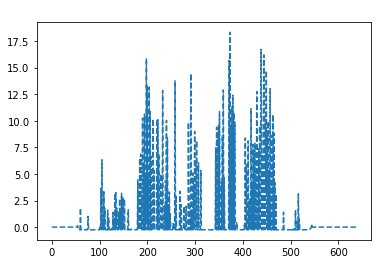

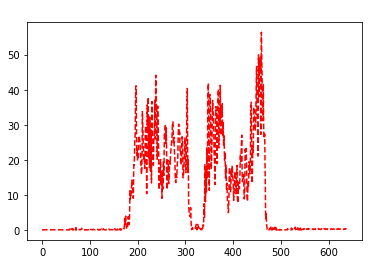

Summary
Log name: 2015_07_15_1638_bamb_4_640
Log length: 511.0
Ground Truth: 640.0 Prediction: 686.0934
MSE: 2124.6 MAE: 46.093384 Accuracy: 92.7979089319706 %


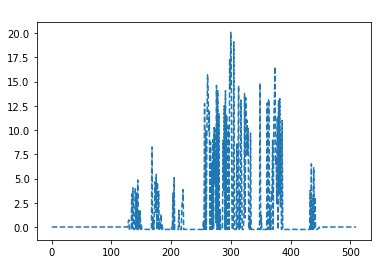

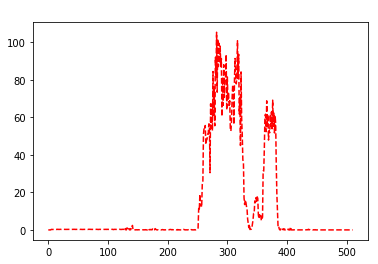

Summary
Log name: 2015_07_15_1647_bamb_5_635
Log length: 397.0
Ground Truth: 635.0 Prediction: 661.7131
MSE: 713.5883 MAE: 26.713074 Accuracy: 95.79321667551994 %


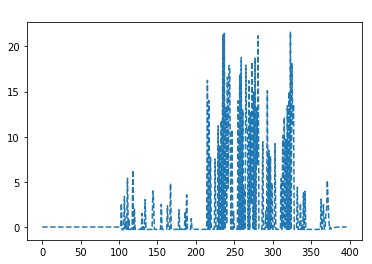

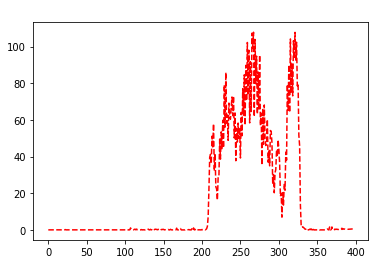

Summary
Log name: 2015_07_15_1656_bamb_6_630
Log length: 408.0
Ground Truth: 630.0 Prediction: 669.44214
MSE: 1555.6823 MAE: 39.44214 Accuracy: 93.73934343457222 %


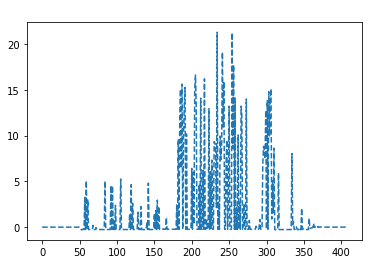

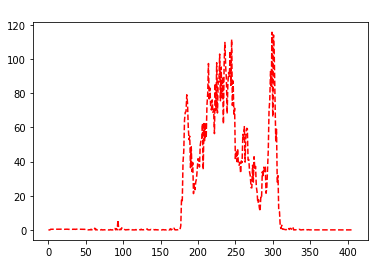

Summary
Log name: 2015_07_15_1700_bamb_7_629
Log length: 292.0
Ground Truth: 629.0 Prediction: 676.9775
MSE: 2301.8384 MAE: 47.977478 Accuracy: 92.37241968512535 %


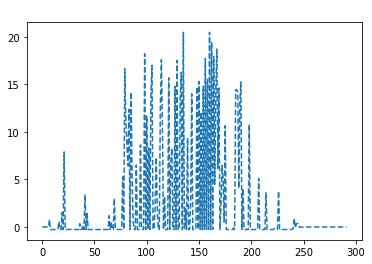

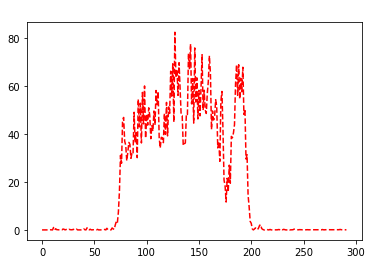

Summary
Log name: 2015_07_15_1702_bamb_8_625
Log length: 1006.0
Ground Truth: 625.0 Prediction: 675.24054
MSE: 2524.1118 MAE: 50.24054 Accuracy: 91.96151345968246 %


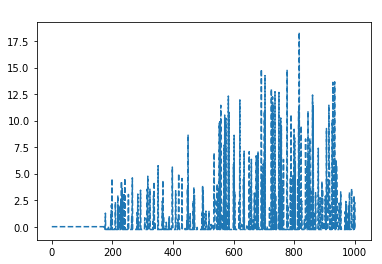

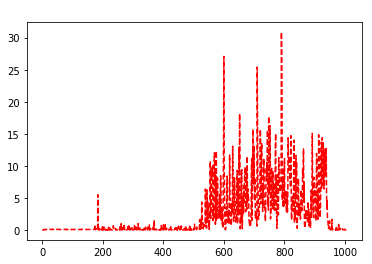

In [14]:
for i, sig in enumerate(signalz):
    prd = np.sum(sig[3])
    gt = np.squeeze(sig[1])
    mse = np.square(gt-prd)
    mae = np.abs(gt-prd)
    ACC = (1-mae/gt)*100
    print('Summary')
    print('Log name:', sig[0])
    print('Log length:', sig[2])
    print('Ground Truth:', gt, 'Prediction:', prd)
    print('MSE:', mse, 'MAE:', mae, 'Accuracy:', ACC,'%')
    plt.title('Mass Predicted Signal', color='white')
    plt.plot(sig[3], '--')
    plt.show()
    plt.title('Volume Signal', color='white')
    plt.plot(sig[4], 'r--')
    plt.show()
    if i>4:
        break

Summary
Log name: 2015_07_21_1232_bamb_80_620
Log length: 302.0
Ground Truth: 620.0 Prediction: 646.7568
MSE: 715.925 MAE: 26.756775 Accuracy: 95.6843912601471 %


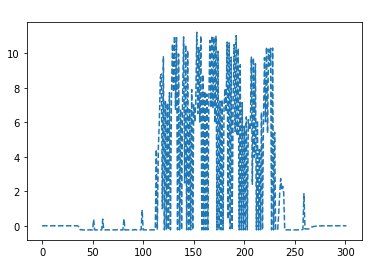

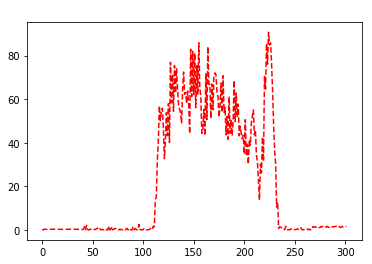

Summary
Log name: 2015_07_21_1234_bamb_81_617
Log length: 332.0
Ground Truth: 617.0 Prediction: 570.8909
MSE: 2126.0464 MAE: 46.10907 Accuracy: 92.52689331769943 %


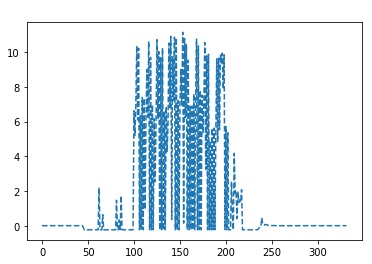

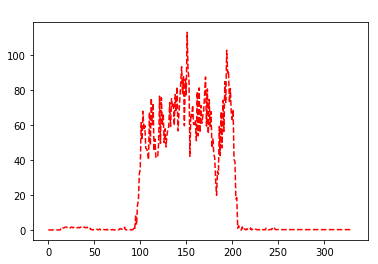

Summary
Log name: 2015_07_22_1502_bamb_82_628
Log length: 744.0
Ground Truth: 628.0 Prediction: 596.8462
MSE: 970.5598 MAE: 31.153809 Accuracy: 95.039202272892 %


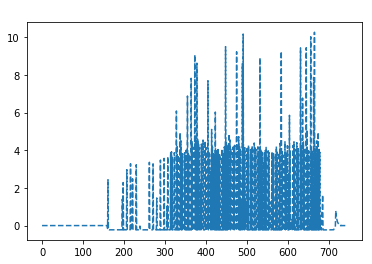

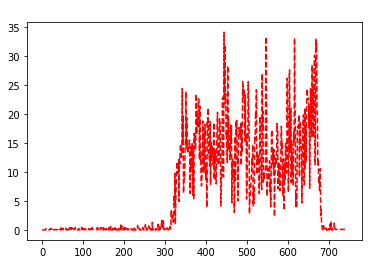

Summary
Log name: 2015_07_22_1506_bamb_83_625
Log length: 601.0
Ground Truth: 625.0 Prediction: 611.1205
MSE: 192.64098 MAE: 13.879517 Accuracy: 97.77927733957767 %


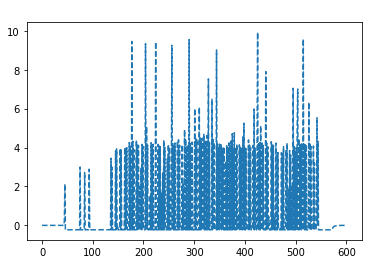

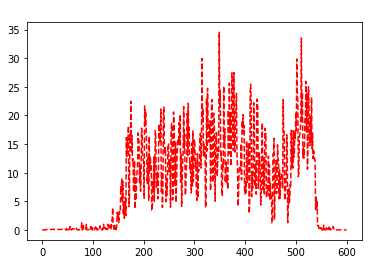

Summary
Log name: 2015_07_22_1510_bamb_84_626
Log length: 484.0
Ground Truth: 626.0 Prediction: 611.4656
MSE: 211.24948 MAE: 14.534424 Accuracy: 97.67820704728365 %


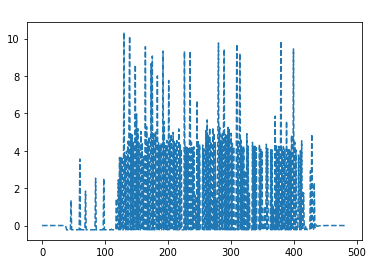

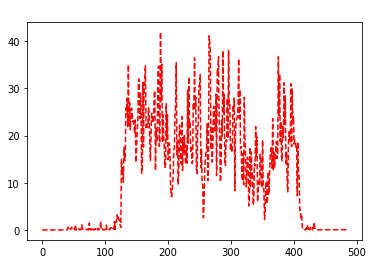

Summary
Log name: 2015_07_22_1513_bamb_85_625
Log length: 473.0
Ground Truth: 625.0 Prediction: 550.5817
MSE: 5538.0796 MAE: 74.418274 Accuracy: 88.09307590126991 %


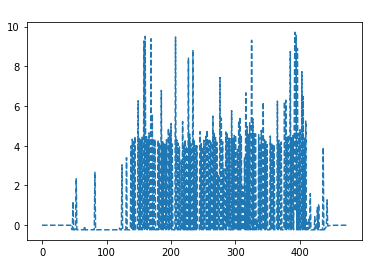

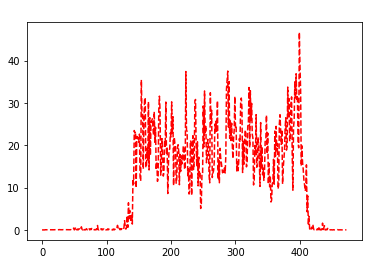

In [17]:
for i, sig in enumerate(signalz):
    prd = np.sum(sig[3])
    gt = np.squeeze(sig[1])
    mse = np.square(gt-prd)
    mae = np.abs(gt-prd)
    ACC = (1-mae/gt)*100
    print('Summary')
    print('Log name:', sig[0])
    print('Log length:', sig[2])
    print('Ground Truth:', gt, 'Prediction:', prd)
    print('MSE:', mse, 'MAE:', mae, 'Accuracy:', ACC,'%')
    plt.title('Mass Predicted Signal', color='white')
    plt.plot(sig[3], '--')
    plt.show()
    plt.title('Volume Signal', color='white')
    plt.plot(sig[4], 'r--')
    plt.show()
    if i>4:
        break

In [38]:
testing_path[0].split('/')[8]

'2015_07_21_1203_bamb_70_630'

In [ ]:

mn = 1
mn_idx = 0
mx = 0
mx_idx = 0
ref_mn = 0
ref_mx = 0
accuracy_mean = 0
cnt = 0
for i, acc in enumerate(Accuracy):
    if acc < mn and acc > 0.56:
        mn= acc
        mn_idx = i
        ref_mn = log_order[i]
    if acc > mx:
        mx = acc
        mx_idx = i 
        ref_mx = log_order[i]
    if acc > 0.56:
        cnt += 1
        accuracy_mean += acc
print(mn, mn_idx, ref_mn, mx, mx_idx, ref_mx, accuracy_mean/cnt*100)

In [27]:
print(len(Accuracy))

45


In [ ]:
# VALIDATION CODE

logs_N = 143
start = time.time()
MAE = []
MSE = []
MSBE = []
Accuracy = []
log_order = []
signals = []
signal = []
metric_mse = []
summed_volume = 0
remainder = 0
iterations = 0
fixed_size = 0
count = 0
new_log = True
cnt_log = -1

for (batch, (images, labels, speeds, log_length)) in enumerate(train_dataset):
        batch += 1
        if new_log:           
            new_log = False
            length = int(log_length[0].numpy() - fixed_size + remainder)
            iterations = int(np.floor(length/Batch_size))
            remainder = int(np.mod(length, Batch_size))
            fixed_size = np.shape(speeds)[0]
            cnt_log += 1
        
        if count < iterations:
            mass_pred = model(images)
            volume = (mass_pred * speeds) * t
            summed_volume += tf.reduce_sum(volume)
            mass = summed_volume.numpy()
            count = count + 1
            signal.append(volume)
            # Compute loss and Apply Gradients
            if count == iterations and remainder == 0:
                loss_unsigned = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L2').numpy())
                loss_outlier = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L1').numpy())
                loss_signed = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='Subtraction').numpy())
                MSE.append(loss_unsigned)
                MAE.append(loss_outlier)
                MSBE.append(loss_signed)
                signals.append(signal[0:len(signal)])
                signal.clear()
                
                GT = np.squeeze(labels[0].numpy())
                if GT >= 200 and GT != 501:  # used for testing
                    metric_mse.append(loss_unsigned)
                    if mass > GT:
                        log_acc = np.squeeze((GT+1)/(mass+1))
                    else:
                        log_acc = np.squeeze((mass+1)/(GT+1))
                    Accuracy.append(log_acc)
                    log_order.append(np.squeeze(log_length[0].numpy()))
                    time_ = time.time() - start
                    validation_progress(cnt_log, logs_N, time_, np.mean(metric_mse), np.mean(Accuracy))

                # Reset

                summed_volume = 0
                count = 0
                fixed_size = 0
                new_log = True
        # Handle the remainder from iterations
        else:
            # Compute and Aggregate the remainder Gradients
            mass_pred = model(images[0:remainder])
            volume = (mass_pred * speeds[0:remainder]) * t
            summed_volume += tf.reduce_sum(volume)
            mass = summed_volume.numpy()
            signal.append(volume)
            loss_unsigned = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L2').numpy())
            loss_outlier = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L1').numpy())
            loss_signed = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='Subtraction').numpy())
            MSE.append(loss_unsigned)
            MAE.append(loss_outlier)
            MSBE.append(loss_signed)
            signals.append(signal[0:len(signal)])
            signal.clear()

            GT = np.squeeze(labels[0].numpy())
            if GT >= 200 and GT != 501:  # used for testing
                metric_mse.append(loss_unsigned)
                if mass > GT:
                    log_acc = np.squeeze((GT+1)/(mass+1))
                else:
                    log_acc = np.squeeze((mass+1)/(GT+1))
                Accuracy.append(log_acc)
                log_order.append(np.squeeze(log_length[0].numpy()))
                time_ = time.time() - start
                validation_progress(cnt_log, logs_N, time_, np.mean(metric_mse), np.mean(Accuracy))        
                
            summed_volume = 0
            count = 0
            new_log = True
            
            # Handle gradients for the next log
            if cnt_log != logs_N-1:    
                mass_pred = model(images[remainder:])
                volume = (mass_pred * speeds[remainder:]) * t
                summed_volume += tf.reduce_sum(volume)
                signal.append(volume)



In [ ]:
# OTHER ACCURACY MEASURE
def accuracy_err(prediction, label):
    accuracy = []
    for i, prd in enumerate(prediction):
        if tf.abs(prd).numpy() > tf.abs(label[i]).numpy():
            acc = np.squeeze(tf.abs(tf.divide(label[i], prd)).numpy())
            if acc != acc:
                acc = 0
            accuracy.append(acc)
        else: 
            acc = np.squeeze(tf.abs(tf.divide(prd, label[i])).numpy())
            if acc != acc:
                acc = 0
            accuracy.append(acc)
    return accuracy

In [ ]:
loss_ = 0
train_N = 57
mass = 0
err = 0
acm_accu = 0
max_acc = 0
min_acc = 1
start = time.time()
aggregated = []
for epoch in range(1):
    
    summed_volume = 0
    remainder = 0
    iterations = 0
    fixed_size = 0
    count = 0
    new_log = True
    append_flag = True
    next_log = False
    cnt_log = -1
    first_run = True
    for (batch, (images, labels, speeds, log_length)) in enumerate(test_dataset):
        batch += 1
        step = tf.train.get_or_create_global_step()
        if new_log:           
            new_log = False
            length = int(log_length[0].numpy() - fixed_size + remainder)
            iterations = int(np.floor(length/Batch_size))
            remainder = int(np.mod(length, Batch_size))
            fixed_size = np.shape(speeds)[0]
            cnt_log += 1
            # print(log_length[0], iterations, fixed_size, remainder)


        if count < iterations:
            mass_pred = model(images)
            volume = (mass_pred * speeds) * t
            if cnt_log ==0:
                print(volume)
            mass += tf.reduce_sum(volume).numpy()
        
            labels = tf.to_float(labels)
            accuracy = accuracy_err(volume, labels)
        
            # print(batch)
            if np.max(accuracy) > max_acc:
                max_acc = np.max(accuracy)
            elif np.min(accuracy) <  min_acc:
                min_acc = np.min(accuracy)
            acm_accu += np.sum(accuracy)


            count = count + 1

            # Compute loss and Apply Gradients
            if count == iterations and remainder == 0:
                avg_acc = acm_accu / log_length[0].numpy()
                # print(mass)
                if mass > labels[0].numpy():
                    log_acc = np.squeeze(labels[0].numpy()/mass)
                else:
                    log_acc = np.squeeze(mass/labels[0].numpy())
                print("Accuracy per log: {:.3%}\nAverage Accuracy per batch: {:.3%}\nMax accuracy per batch: {:.3%}\nMin accuracy per batch: {:.3%} "
                      "\n\n".format(
                    log_acc, avg_acc, max_acc, min_acc))

                # Reset
                summed_volume = 0
                count = 0
                append_flag = True
                fixed_size = 0
                new_log = True
                mass = 0
        # Handle the remainder from iterations
        else:
            # Compute and Aggregate the remainder Gradients
            mass_pred = model(images[0:remainder])
            volume = (mass_pred * speeds[0:remainder]) * t
            if cnt_log == 0:
                print(volume)
            mass += tf.reduce_sum(volume).numpy()
        
            labels = tf.to_float(labels)
            accuracy = accuracy_err(volume, labels)
        
            # print(batch)
            if np.max(accuracy) > max_acc:
                max_acc = np.max(accuracy)
            elif np.min(accuracy) <  min_acc:
                min_acc = np.min(accuracy)
            acm_accu += np.sum(accuracy)

            avg_acc = acm_accu / log_length[0].numpy()
            print(mass)
            if mass > labels[0].numpy():
                log_acc = np.squeeze(labels[0].numpy()/mass)
            else:
                log_acc = np.squeeze(mass/labels[0].numpy())
            print("Accuracy per log: {:.3%}\nAverage Accuracy per batch: {:.3%}\nMax accuracy per batch: {:.3%}\nMin accuracy per batch: {:.3%} \n\n".format(
                log_acc, avg_acc, max_acc, min_acc))
            

            summed_volume = 0
            count = 0
            append_flag = True
            new_log = True
            mass = 0
            
            # Handle gradients for the next log
            if cnt_log != train_N-1:
                
                mass_pred = model(images[remainder:])
                volume = (mass_pred * speeds[remainder:]) * t
                # print(volume)
                mass += tf.reduce_sum(volume).numpy()
            
                labels = tf.to_float(labels)
                accuracy = accuracy_err(volume, labels)
            
                # print(batch)
                if np.max(accuracy) > max_acc:
                    max_acc = np.max(accuracy)
                elif np.min(accuracy) <  min_acc:
                    min_acc = np.min(accuracy)
                acm_accu += np.sum(accuracy)

